#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 18
**CH18B Forecasting a home price index**

using case-schiller-la dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings
from datetime import datetime
import pyfixest as pf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error


warnings.filterwarnings("ignore")

In [2]:
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]
data_in = dirname + "da_data_repo/case-shiller-la/clean/"
data_out = dirname + "da_case_studies/ch18-case-shiller-la/"
output = dirname + "da_case_studies/ch18-case-shiller-la/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

from py_helper_functions import *
sns.set_theme(rc=da_theme, palette=color)

In [3]:
csv_path = os.path.join(data_in, "homeprices-data-2000-2018.csv")
data = pd.read_csv(csv_path)
#data = pd.read_csv("https://osf.io/download/n3jty/")



In [4]:
data.head()


,date,year,month,ps,pn,us,un,emps,empn
0,2000-01-01,2000,1,101.031209,100.00000,5.0,5.4,14344.4,14132.8
1,2000-02-01,2000,2,102.043406,100.61896,5.0,5.3,14390.4,14270.0
2,2000-03-01,2000,3,103.224699,102.12780,5.0,5.3,14429.1,14421.3
3,2000-04-01,2000,4,104.159399,103.70410,5.0,4.7,14484.6,14450.8
4,2000-05-01,2000,5,104.924698,104.98908,5.0,4.7,14549.9,14590.2


In [5]:
data = data.assign(date=lambda x: x.date.str[0:7])

data = data.rename({"pn": "p", "us": "u", "emps": "emp"}, axis=1)


In [6]:
data = data.sort_values(by=["date"]).assign(
    dp=lambda x: x.p.diff(1),
    p_lag=lambda x: x.p.shift(1),
    lnp=lambda x: np.log(x.p),
    dlnp=lambda x: x.lnp.diff(1),
    lnp_lag=lambda x: x.lnp.shift(1),
    dlnp_lag=lambda x: x.dlnp.shift(1),
    du=lambda x: x.u.diff(1),
    lnemp=lambda x: np.log(x.emp),
    dlnemp=lambda x: x.lnemp.diff(1),
    trend=lambda x: range(1, data.shape[0] + 1),
)


In [7]:
# now save the workfile with data from 2000 through 2018

data.to_pickle("case-shiller-workfile-2000-2018.pkl")


In [8]:
# and now create and save the workfile with data from 2000 through 2017

data = data.loc[lambda x: x.year <= 2017]
data.to_pickle("case-shiller-workfile-2000-2017.pkl")


### Figure 18.8


In [9]:
data["date"] = data["date"].astype("datetime64[ns]")

In [10]:
def custom_xaxis_date_format():
    plt.xlim(pd.to_datetime("2000-01-01"), pd.to_datetime("2018-01-01"))
    plt.xticks(
        pd.to_datetime(
            [
                "2000-01-01",
                "2003-01-01",
                "2006-01-01",
                "2009-01-01",
                "2012-01-01",
                "2015-01-01",
                "2018-01-01",
            ]
        )
    )
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b%Y"))

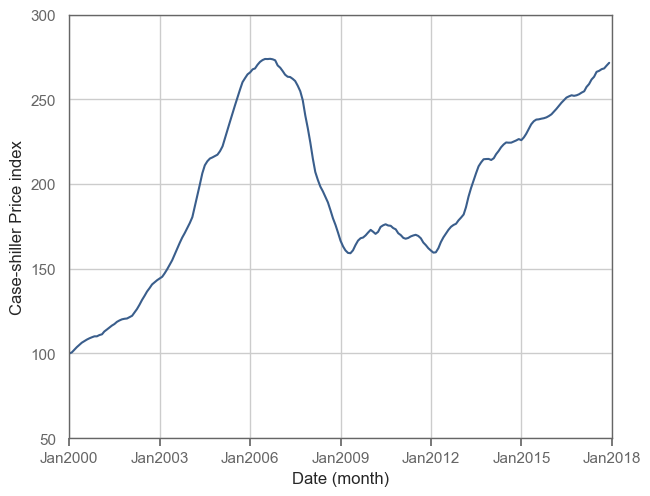

In [11]:
sns.lineplot(data=data, x="date", y="p", linewidth=1.5)

plt.ylim(50, 300)
plt.yticks(range(50, 301, 50))
custom_xaxis_date_format()
plt.ylabel("Case-shiller Price index")
plt.xlabel("Date (month)")
plt.show()

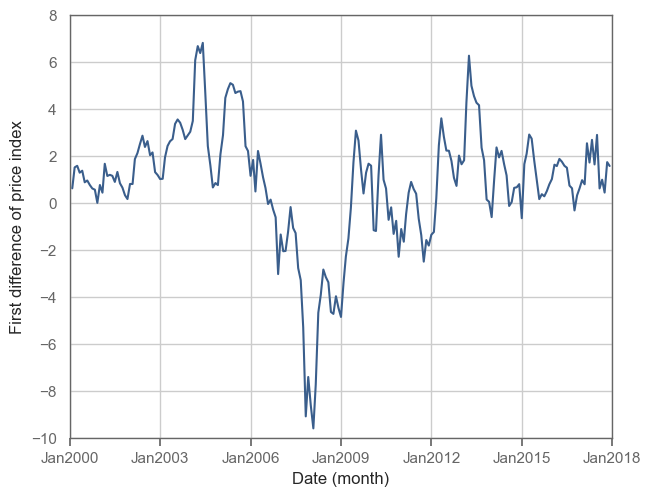

In [12]:
# additional graphs, not in textbook
# Plot first difference of price index

sns.lineplot(data=data, x="date", y="dp", linewidth=1.5)

plt.ylim(-10, 8)
plt.yticks(range(-10, 9, 2))
custom_xaxis_date_format()
plt.ylabel("First difference of price index")
plt.xlabel("Date (month)")
plt.show()

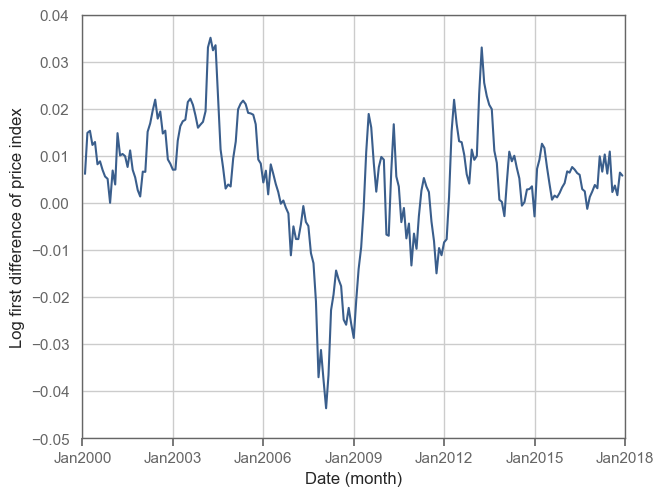

In [13]:
# Plot log difference of price index
sns.lineplot(data=data, x="date", y="dlnp", linewidth=1.5)
plt.ylim(-0.05, 0.04)
plt.yticks(np.arange(-0.05, 0.05, 0.01))
custom_xaxis_date_format()
plt.ylabel("Log first difference of price index")
plt.xlabel("Date (month)")
plt.show()

### Figure 18.10

#### (a) Unemployment rate

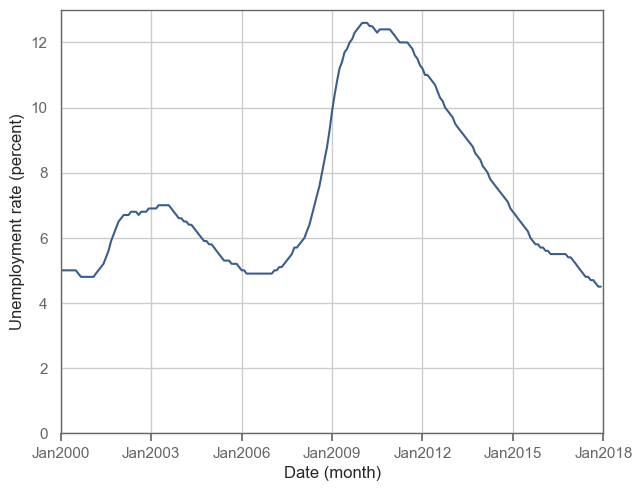

In [14]:
sns.lineplot(data=data, x="date", y="u", linewidth=1.5)
plt.yticks(range(0, 13, 2))
custom_xaxis_date_format()
plt.ylabel("Unemployment rate (percent)")
plt.xlabel("Date (month)")
plt.show()

#### (b) Change of unemployment rate

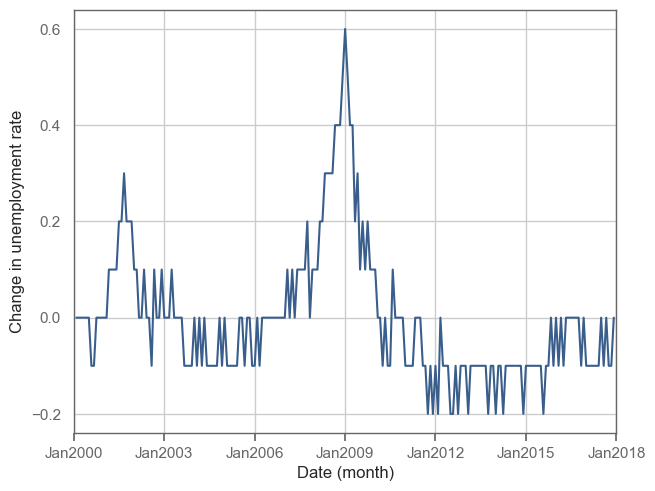

In [15]:
sns.lineplot(data=data, x="date", y="du", linewidth=1.5)
plt.yticks(np.arange(-0.2, 0.7, 0.2))
custom_xaxis_date_format()
plt.ylabel("Change in unemployment rate")
plt.xlabel("Date (month)")
plt.show()

#### (c) Total employment (thousands)

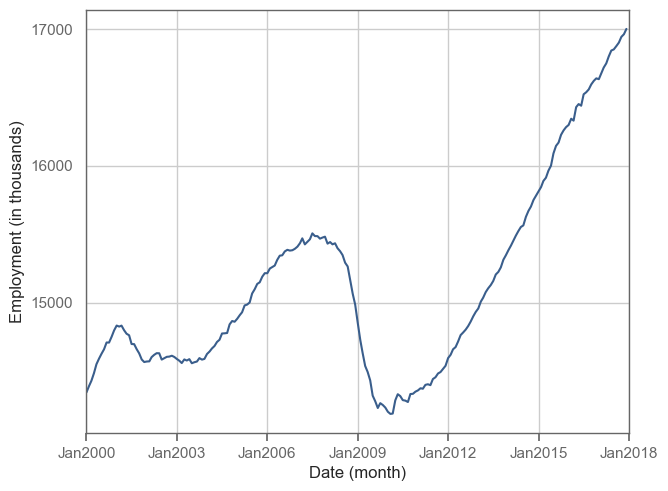

In [16]:
sns.lineplot(data=data, x="date", y="emp", linewidth=1.5)
plt.yticks([15000, 16000, 17000])
custom_xaxis_date_format()
plt.ylabel("Employment (in thousands)")
plt.xlabel("Date (month)")
plt.show()

#### (d) Log change of total employment

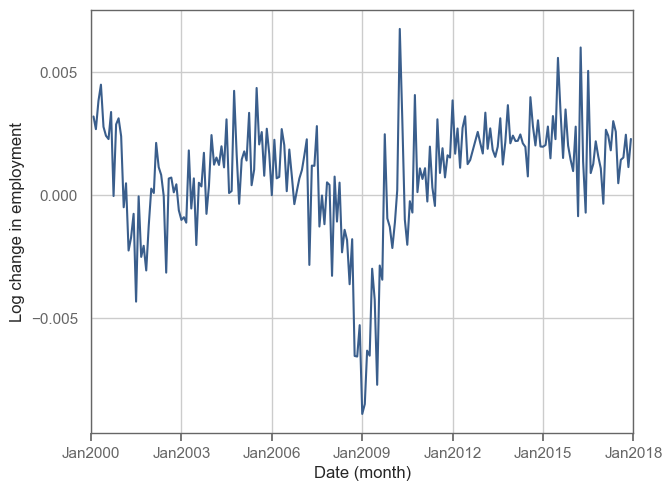

In [17]:
sns.lineplot(data=data, x="date", y="dlnemp", linewidth=1.5)
plt.yticks([-0.005, 0, 0.005])
custom_xaxis_date_format()
plt.ylabel("Log change in employment")
plt.xlabel("Date (month)")
plt.show()

### Create work set and holdout set

In [18]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2017, :]
data_work = data.loc[lambda x: x["year"] < 2017, :]


In [19]:
# create training and test sets for 4 folds

for year in range(2013, 2017):
    fold = year - 2012
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (data_work["year"] <= year - 1) & (
        data_work["year"] >= year - 13
    )


In [20]:
# Model M1
# p on trend & seasonality
mse_1 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model1 = pf.feols("p ~ trend + C(month)", train_data)

    phat = model1.predict(test_data)

    errsq = np.square(test_data.p.values - phat)

    mse_1.append(np.mean(errsq))

rmse_cv_m1 = np.sqrt(np.mean(mse_1))

In [21]:
rmse_cv_m1

31.925055127820933

In [22]:
# Model M2
# p ARIMA(1,1,2)

# Get order from auto_arima

auto_arima_m2 = auto_arima(
    y=data_work.p,
    start_p=0,
    max_p=1,  # without this constrain, python returns other ARIMA order
    max_order=0,
    seasonal=False,
)

mse_2 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model2 = ARIMA(train_data.p, order=auto_arima_m2.get_params()["order"]).fit()

    phat = model2.forecast(steps=12)

    errsq = np.square(test_data.p.values - phat)

    mse_2.append(np.mean(errsq))

rmse_cv_m2 = np.sqrt(np.mean(mse_2))


In [23]:
# Model M3
# p ARIMA(1,1,0)

# Get order from auto_arima

auto_arima_m3 = auto_arima(
    y=data_work.p, X=pd.get_dummies(data_work.month).astype(int), max_order=0, seasonal=False
)

mse_3 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model3 = ARIMA(
        train_data.p,
        exog=pd.get_dummies(train_data.month),
        order=auto_arima_m3.get_params()["order"],
    ).fit()

    phat = model3.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    errsq = np.square(test_data.p.values - phat)

    mse_3.append(np.mean(errsq))

rmse_cv_m3 = np.sqrt(np.mean(mse_3))


In [24]:
# Model M4
# p ARIMA(2,0,0) + seasonality + trend

X_m4 = pd.get_dummies(data_work.month).astype(int)
X_m4[13] = data_work.trend

# Get order from auto_arima
auto_arima_m4 = auto_arima(
    y=data_work.p,
    X=X_m4,
    max_order=0,
    seasonal=False,
)

mse_4 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model4 = ARIMA(
        train_data.p,
        exog=pd.get_dummies(train_data.month).astype(int),
        trend="t",
        order=auto_arima_m4.get_params()["order"],
    ).fit()

    phat = model4.forecast(steps=12, exog=pd.get_dummies(test_data.month), trend="t")

    errsq = np.square(test_data.p.values - phat)

    mse_4.append(np.mean(errsq))

rmse_cv_m4 = np.sqrt(np.mean(mse_4))


In [25]:
# Model M5
# dp ~ month + trend, without any ARIMA
mse_5 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model5 = pf.feols("dp ~ trend + C(month)", train_data)

    dphat = model5.predict(test_data)

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_5.append(np.mean(errsq))

rmse_cv_m5 = np.sqrt(np.mean(mse_5))

In [26]:
rmse_cv_m5

18.78202953776918

In [27]:
# Model M6
# lnp ARIMA(0,2,0) + seasonality

# Get order from auto_arima
auto_arima_m6 = auto_arima(
    y=data_work.lnp,
    X=pd.get_dummies(data_work.month).astype(int),
    d=2,  # without this constrain, python returns other ARIMA order
    max_order=0,
    seasonal=True,
)

mse_6 = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1]
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1]

    model6 = ARIMA(
        train_data.lnp,
        exog=pd.get_dummies(train_data.month),
        order=auto_arima_m6.get_params()["order"],
    ).fit()

    lnphat = model6.forecast(steps=12, exog=pd.get_dummies(test_data.month))

    corrb = mean_squared_error(test_data.lnp, lnphat)

    phat = np.exp((lnphat + corrb / 2))

    errsq = np.square(test_data.p.values - phat)

    mse_6.append(np.mean(errsq))

rmse_cv_m6 = np.sqrt(np.mean(mse_6))


In [28]:
# VAR

mse_var = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7 = VAR(train_data[["dp", "du", "dlnemp"]]).fit(1)

    dphat = model7.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7.k_ar :], steps=12
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var.append(np.mean(errsq))

rmse_cv_m7 = np.sqrt(np.mean(mse_var))


In [29]:
# Note. This VAR includes month dummies
# Textbook results are from R, where
# we could not figure out how to include month dummies

mse_var_season = []
for i in range(1, 5):

    train_data = data_work.loc[lambda x: x["train" + str(i)] == 1, :].dropna()
    test_data = data_work.loc[lambda x: x["test" + str(i)] == 1, :].dropna()

    model7_season = VAR(
        train_data[["dp", "du", "dlnemp"]], exog=pd.get_dummies(train_data["month"])
    ).fit(1)

    dphat = model7_season.forecast(
        train_data[["dp", "du", "dlnemp"]].values[-model7_season.k_ar :],
        exog_future=pd.get_dummies(test_data["month"]).values,
        steps=12,
    )[:, 0]

    test_data["phat"] = None
    for i in range(0, 12):
        if i == 0:
            test_data.iloc[i, -1] = train_data["p"].values[-1] + dphat[i]
        else:
            test_data.iloc[i, -1] = test_data.iloc[i - 1, -1] + dphat[i]

    errsq = np.square(test_data["p"] - test_data["phat"])

    mse_var_season.append(np.mean(errsq))

rmse_cv_m7_season = np.sqrt(np.mean(mse_var_season))


In [30]:
# Note: some model's cv rmse is different from textbook

pd.DataFrame(
    [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6, mse_var],
    columns=["Fold" + str(i) for i in range(1, 5)],
).apply(np.sqrt).assign(
    Average=[
        rmse_cv_m1,
        rmse_cv_m2,
        rmse_cv_m3,
        rmse_cv_m4,
        rmse_cv_m5,
        rmse_cv_m6,
        rmse_cv_m7,
    ],
    model=["M" + str(i) for i in range(1, 7)] + ["M7 (var)"],
).round(
    2
).set_index(
    "model"
)


,Fold1,Fold2,Fold3,Fold4,Average
model,,,,,
M1,14.90,17.59,34.43,48.58,31.93
M2,14.82,8.39,6.23,5.53,9.48
M3,6.68,1.39,3.28,3.22,4.12
M4,3.01,1.24,1.37,2.06,2.04
M5,33.94,9.79,10.42,7.39,18.78
M6,2.52,4.98,9.40,9.79,7.34
M7 (var),13.90,6.33,3.40,3.63,8.03


In [31]:
print("RMSE for VAR with seasonality (not in book):", rmse_cv_m7_season)


RMSE for VAR with seasonality (not in book): 4.531352403195177


### predict for holdout

In [32]:
# best model is M4
# re-estimate best models on full work set
model_final = ARIMA(
    data_work.p, exog=pd.get_dummies(data_work.month).astype(int), trend="t", order=(2, 0, 0)
).fit()


In [33]:
pred_final = model_final.get_forecast(
    steps=12, exog=pd.get_dummies(data_holdout.month), trend="t"
)


In [34]:
forecast_holdout_best = (
    data_holdout.assign(p_pred=pred_final.predicted_mean.values, model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)


In [35]:
plot_data = (
    data.join(forecast_holdout_best)
    .loc[lambda x: x.year >= 2015]
    .reset_index(drop=True)
)


### Figure 18.9

In [36]:
def ts_plot(plot_data: pd.DataFrame, add_conf_int: bool = False):
    """
    Plots time series data with optional confidence intervals.
    Parameters:
    plot_data (pd.DataFrame): DataFrame containing the time series data to plot.
                              It should have columns 'date', 'p', 'p_pred', 'lower p', and 'upper p'.
    add_conf_int (bool): If True, adds a confidence interval shaded area between 'lower p' and 'upper p'. Default is False.
    Returns:
    None: The function displays a plot.
    The plot includes:
    - A line plot of actual and predicted values over time.
    - Optional confidence intervals shaded area.
    - Customized legend and axis labels.
    """

    plot_data = pd.melt(
        plot_data.filter(["date", "p", "p_pred", "lower p", "upper p"]),
        ["date", "lower p", "upper p"],
    )

    sns.lineplot(data=plot_data, x="date", y="value", hue="variable", linewidth=2.5)

    if add_conf_int:
        plt.fill_between(
            plot_data.date,
            plot_data["lower p"],
            plot_data["upper p"],
            color=color[1],
            alpha=0.1,
        )

    handles, _ = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles=handles,
        labels=["Actual", "Prediction"],
        loc="center",
        bbox_to_anchor=(0.74, 0.15),
        ncol=2,
        frameon=False,
    )
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b%Y"))
    plt.ylabel("Case-Shiller Home Price Index")
    plt.xlabel("Date (month)")
    plt.show()

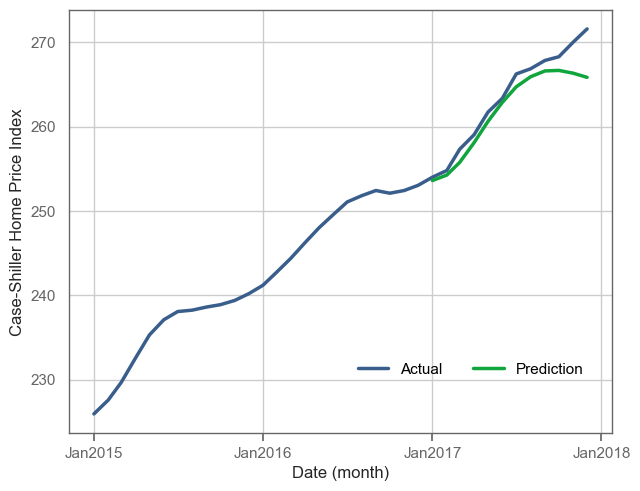

In [37]:
ts_plot(plot_data)

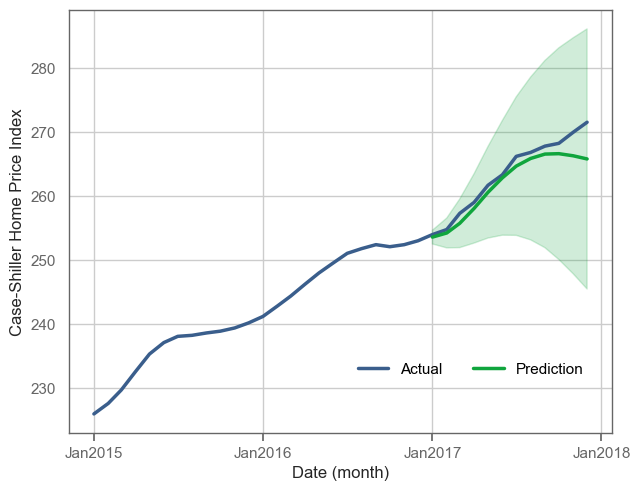

In [38]:
ts_plot(plot_data, add_conf_int=True)

In [39]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout


4.930296858661369

### EXTERNAL VALIDITY
### do the prediction for an extra year

In [40]:
data = pd.read_pickle("case-shiller-workfile-2000-2018.pkl")


In [41]:
data["date"] = data["date"].apply(lambda x: datetime.strptime(x, "%Y-%m"))


In [42]:
# create work and holdout sets
data_holdout = data.loc[lambda x: x["year"] == 2018, :]
data_work = data.loc[lambda x: x["year"] < 2018, :]


In [43]:
# best model is M4
# re-estimate best models on full work set
model_final = ARIMA(
    data_work.p, exog=pd.get_dummies(data_work.month).astype(int), trend="t", order=(2, 0, 0)
).fit()


In [44]:
pred_final = model_final.get_forecast(
    steps=12, exog=pd.get_dummies(data_holdout.month), trend="t"
)


In [45]:
forecast_holdout_best = (
    data_holdout.assign(p_pred=pred_final.predicted_mean.values, model="best")
    .join(pred_final.conf_int(alpha=0.2))
    .filter(["model", "p_pred", "lower p", "upper p"])
)


In [46]:
plot_data_holdout = (
    data.join(forecast_holdout_best)
    .loc[lambda x: x.year >= 2015]
    .reset_index(drop=True)
)

### Figure 18.11 Prediction on new holdout

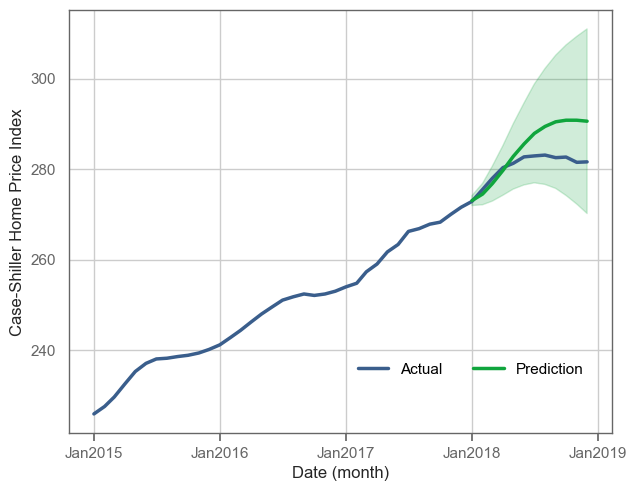

In [47]:
ts_plot(plot_data_holdout, add_conf_int=True)

In [48]:
errsq = np.square(data_holdout.p.values - forecast_holdout_best.p_pred)

rmse_holdout = np.mean(errsq)
rmse_holdout


31.169442140726332